**Author:** Elias Rafael Ruiz-Morales

**Institution:** Wellcome Sanger institute

**July, 2023**


---

##  1 - Preprocessing *T. gondii*

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib
import os
import sys
%matplotlib inline
import seaborn as sns
import seaborn as sb
from glob import iglob
import anndata
import matplotlib as mpl
import skmisc

    
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = '../results/images/preprocessing/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable


fig_path= '../results/images/preprocessing/'

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.1
dateutil            2.8.1
decorator           4.4.2
fsspec              0.8.7
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyterlab_server   2.3.0
kiwisolver          1.3.1


In [2]:
def Barplot(which_var, adata, var='identity', height=3, color = False, suffix= ''):
    
    '''
    Function to plot barplots plotting the proportion of cells per catergory in var, coming from each category in which_var.
    
    Parameters:
        which_var: column name in .obs. Contains the categories to contrast.
        adata: anndata object.
        var: column name in .obs. It contains the categories of the cells.
        height: plot height
        color: colors to use
        suffix: string. Suffix to be added at the end of the name of the plot.
    
    Return:
        Saves bar plot as a pdf.
        
    '''
    
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if 'category' in plotdata.index.dtype.name:
        plotdata.index.reorder_categories(adata.obs[var].cat.categories[::-1])

    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
    ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+ suffix+'.pdf', bbox_inches='tight',
                       dpi=300, orientation='landscape', format= 'pdf', optimize=True)

In [3]:
### Function to add the souporcell cluster
####

def add_souporcell_id(adata_obj, cell_id, samples):
    '''
    Function to add the souporcell status (e.g. 0,1, not pooled, etc.) to the cells
    
    Input
        adata_obj: adata object
        cell_id: id of a cell
        samples: list of samples that were pooled. Usually not all samples are multiplexed.
    
    '''
    
    curr_sample = adata_obj.obs.loc[cell_id, 'sample']
    
    #print('sample',sample, 'barcode', cell_id)
    
    if curr_sample in samples:
        #extracts the table contained in the indicated key of the dictionary
        curr_souporcell_table = souporcell_clusters[curr_sample]
        
        if (cell_id in list(curr_souporcell_table.index)): #checking that the cells are into the data
            curr_assign = souporcell_clusters[curr_sample].loc[cell_id,'assignment']
            #print('returning',curr_assign)
            return(curr_assign)

        else:
            # cell barcode is filtered by souporcell
            return('filtered_by_souporcell')
    else:
        return('not_pooled')

In [4]:
def decode_donors(adata_obj, cell_id, identity_dict,samples):

    '''
    Function to add the true identity to the multiplexed samples. The souporcell samples are changed
    to the real names of the clusters(e.g. 0= Hrv99, 1=Hrv98).
    
    Input
        adata_obj: adata object
        cell_id: id of a cell
        identity_dict: dictionary with the identity of each cluster per each sample. It has the structure sample:{cluster:donor}.
        samples: list of samples to be considered in the function. Not all samples are multiplexed
    '''
    
    
    #sample name
    curr_sample = adata_obj.obs.loc[cell_id, 'sample']
    
    #cluster name
    curr_souporcell_cluster = adata_obj.obs.loc[cell_id, 'assignment_SoC']

    if curr_sample in samples:
        #this means that the cell could not be assigned to a cluster (e.g. 2/3), therefore it is considered as a doublet
        if '/' in curr_souporcell_cluster:
            return('donor_doublets')
        
        #Condition for cells that were filtered by SoC. These will be deleted later.
        elif "filtered" in curr_souporcell_cluster:
            return('filtered_by_souporcell')
        
        #Singlets with a donor assigned
        else:
            return(identity_dict[curr_sample][curr_souporcell_cluster])


        


### Import data

In [5]:
data_dir ='/lustre/scratch126/cellgen/team292/er13/PlacInfection_revision/scRNAseq/data_integration/data/Toxoplasma/'

meta = pd.read_csv(data_dir+'meta_exp_infection_Tg_scell.csv',index_col=0)
meta['donor'] = meta['donor'].astype('str')
plotmeta = list(meta.columns)
plotmeta.append('sample')
print('Number of samples: ', meta.index.size)

Number of samples:  4


In [6]:
meta

,stage,donor,hpi,infection
sample,,,,
Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI
Pla_HDBR13007975,Tg_24h,Hrv171_Hrv172,24h,Tg
Pla_HDBR13798223,UI_24h,Hrv241_Hrv242,24h,UI
Pla_HDBR13798224,Tg_24h,Hrv241_Hrv242,24h,Tg


### Preprocessing

No basic filtering at this stage to keep integrate the parasite genes

Quantify: 1) % mitochondrial genes; 2) total counts

In [7]:
holder = []
for sample in meta.index:
    print(sample)
    # Load 10x data as AnnData

    holder.append(sc.read_10x_mtx(data_dir+sample+'/output/GeneFull/filtered/',var_names='gene_symbols',cache=True)) 
    print('Original number of cells: {:d}'.format(holder[-1].n_obs))
    
    holder[-1].var_names_make_unique()
    holder[-1].obs_names = [sample+'_'+i.split('-')[0] for i in holder[-1].obs_names]
    
    
    # Filer cells with less than 100 genes expressed
    #sc.pp.filter_cells(holder[-1], min_genes=100)
    
    #Filer genes expressed in less than 3 cells
    #sc.pp.filter_genes(holder[-1], min_cells=3)
    
    
    # add in metadata
    holder[-1].obs['sample'] = sample
    for val in meta.columns:
        holder[-1].obs[val] = meta[val][sample]
    
    # Extract mitochondial genes
    mito_genes = [name for name in holder[-1].var_names if name.startswith('MT-')]
    #for each cell compute fraction of counts in mito genes vs. all genes
    #the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
    holder[-1].obs['percent_mito'] = np.sum(
         holder[-1][:, mito_genes].X, axis=1).A1 / np.sum(holder[-1].X, axis=1).A1
    
    #add the total counts per cell as observations-annotation to adata
    holder[-1].obs['n_counts'] = holder[-1].X.sum(axis=1).A1
    
    print('Total number of cells: {:d}'.format(holder[-1].n_obs))
    print('Total number of genes: {:d}'.format(holder[-1].n_vars))

Pla_HDBR13007974
Original number of cells: 16274
Total number of cells: 16274
Total number of genes: 45238
Pla_HDBR13007975
Original number of cells: 17962
Total number of cells: 17962
Total number of genes: 45238
Pla_HDBR13798223
Original number of cells: 16936
Total number of cells: 16936
Total number of genes: 45238
Pla_HDBR13798224
Original number of cells: 16642
Total number of cells: 16642
Total number of genes: 45238


In [8]:
# confirm N samples
print(len(holder))
# merge datasets by taking the intersection of cells found between cells 
adata = holder[0].concatenate(holder[1:],join='outer',index_unique=None)
# copy of this matrix in Compressed Sparse Row format
adata.X = adata.X.tocsr()
adata

4


AnnData object with n_obs × n_vars = 67814 × 45238
    obs: 'sample', 'stage', 'donor', 'hpi', 'infection', 'percent_mito', 'n_counts', 'batch'
    var: 'gene_ids', 'feature_types'

In [9]:
adata.obs.head()

,sample,stage,donor,hpi,infection,percent_mito,n_counts,batch
Pla_HDBR13007974_AAACCCAAGAAGAGCA,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.001482,5397.0,0
Pla_HDBR13007974_AAACCCAAGCGTTGTT,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.019590,6432.0,0
Pla_HDBR13007974_AAACCCAAGTAGTCAA,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.045489,49221.0,0
Pla_HDBR13007974_AAACCCACAATGAACA,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.045332,9243.0,0
Pla_HDBR13007974_AAACCCACAGAGAGGG,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.031214,7753.0,0


# Souporcell
Adding another column with deconvolution from souporcell

In [10]:
samples = list(np.unique(adata.obs['sample']))

In [11]:
samples

['Pla_HDBR13007974',
 'Pla_HDBR13007975',
 'Pla_HDBR13798223',
 'Pla_HDBR13798224']

In [12]:
###reading in souporcell outputs
###

soc_path='/lustre/scratch126/cellgen/team292/er13/PlacInfection_revision/scRNAseq/data_integration/data/Toxoplasma/souporcell_donor/'

# sample to cluster
souporcell_clusters = {}


for sample in samples:
    print('sample', sample)
    path =soc_path+sample+'/soc2/clusters.tsv' #path to the souporcell output
    souporcell_clusters[sample] = pd.read_csv(path, sep='\t') #read souporcell output as pandas DF
    #aadind the DF into the dictionary
    souporcell_clusters[sample]['sample_barcode'] = [sample+'_'+j for j in souporcell_clusters[sample]['barcode']]
    souporcell_clusters[sample]['sample_barcode'] = [elem.split('-')[0] for elem in souporcell_clusters[sample]['sample_barcode']]
    souporcell_clusters[sample].set_index('sample_barcode', drop=False, inplace=True)

sample Pla_HDBR13007974
sample Pla_HDBR13007975
sample Pla_HDBR13798223
sample Pla_HDBR13798224


In [13]:
#Adding a column into the metada that is actually the cell ID
adata.obs['sample_barcode'] = adata.obs.index

In [14]:
%%time
adata.obs['assignment_SoC'] = adata.obs['sample_barcode'].apply(lambda x: add_souporcell_id(adata,x,samples))

CPU times: user 1min 19s, sys: 0 ns, total: 1min 19s
Wall time: 1min 19s


In [15]:
adata.obs

,sample,stage,donor,hpi,infection,percent_mito,n_counts,batch,sample_barcode,assignment_SoC
Pla_HDBR13007974_AAACCCAAGAAGAGCA,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.001482,5397.0,0,Pla_HDBR13007974_AAACCCAAGAAGAGCA,0
Pla_HDBR13007974_AAACCCAAGCGTTGTT,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.019590,6432.0,0,Pla_HDBR13007974_AAACCCAAGCGTTGTT,1
Pla_HDBR13007974_AAACCCAAGTAGTCAA,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.045489,49221.0,0,Pla_HDBR13007974_AAACCCAAGTAGTCAA,0
Pla_HDBR13007974_AAACCCACAATGAACA,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.045332,9243.0,0,Pla_HDBR13007974_AAACCCACAATGAACA,1
Pla_HDBR13007974_AAACCCACAGAGAGGG,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.031214,7753.0,0,Pla_HDBR13007974_AAACCCACAGAGAGGG,1
...,...,...,...,...,...,...,...,...,...,...
Pla_HDBR13798224_TTTGTTGTCCTGTTAT,Pla_HDBR13798224,Tg_24h,Hrv241_Hrv242,24h,Tg,0.703766,1779.0,3,Pla_HDBR13798224_TTTGTTGTCCTGTTAT,1/0
Pla_HDBR13798224_TTTGTTGTCGTAGAGG,Pla_HDBR13798224,Tg_24h,Hrv241_Hrv242,24h,Tg,0.209441,11101.0,3,Pla_HDBR13798224_TTTGTTGTCGTAGAGG,1
Pla_HDBR13798224_TTTGTTGTCTCATGGA,Pla_HDBR13798224,Tg_24h,Hrv241_Hrv242,24h,Tg,0.072021,45945.0,3,Pla_HDBR13798224_TTTGTTGTCTCATGGA,1
Pla_HDBR13798224_TTTGTTGTCTCCACTG,Pla_HDBR13798224,Tg_24h,Hrv241_Hrv242,24h,Tg,0.748331,1947.0,3,Pla_HDBR13798224_TTTGTTGTCTCCACTG,1/0


#### Deconvolution of the donors
This step must be done even if there are not defined donors, in order to annotate the doublets.
The deconvolution of cluster equivalents was done using SoC shared_samples.py script. The loss values for true pairs must be low, in some cases, 1/10th that of invalid pairs.

In [16]:
### Building a dictionary with the identity of the cluster in each one of the samples.
### It has the structure SAMPLE:{Cluster:Donor,Cluster:Donor}

identity_dict={
    "Pla_HDBR13007974":{'0':'0','1':'1'},
    "Pla_HDBR13007975":{'0':'1','1':'0'},

    #to avoid repetition of clusters between multiplexed samples for these samples 0=2, 1=3
    "Pla_HDBR13798223":{'0':'2','1':'3'},
    "Pla_HDBR13798224":{'0':'3','1':'2'},
}

identity_dict

{'Pla_HDBR13007974': {'0': '0', '1': '1'},
 'Pla_HDBR13007975': {'0': '1', '1': '0'},
 'Pla_HDBR13798223': {'0': '2', '1': '3'},
 'Pla_HDBR13798224': {'0': '3', '1': '2'}}

In [17]:
%%time
#NOTE: cells that weren't pooled will have None in the donor_deconv column
adata.obs['donor_deconv'] = adata.obs['sample_barcode'].apply(lambda x: decode_donors(adata,x,identity_dict, samples))

CPU times: user 958 ms, sys: 0 ns, total: 958 ms
Wall time: 958 ms


In [18]:
adata.obs.head()

,sample,stage,donor,hpi,infection,percent_mito,n_counts,batch,sample_barcode,assignment_SoC,donor_deconv
Pla_HDBR13007974_AAACCCAAGAAGAGCA,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.001482,5397.0,0,Pla_HDBR13007974_AAACCCAAGAAGAGCA,0,0
Pla_HDBR13007974_AAACCCAAGCGTTGTT,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.019590,6432.0,0,Pla_HDBR13007974_AAACCCAAGCGTTGTT,1,1
Pla_HDBR13007974_AAACCCAAGTAGTCAA,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.045489,49221.0,0,Pla_HDBR13007974_AAACCCAAGTAGTCAA,0,0
Pla_HDBR13007974_AAACCCACAATGAACA,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.045332,9243.0,0,Pla_HDBR13007974_AAACCCACAATGAACA,1,1
Pla_HDBR13007974_AAACCCACAGAGAGGG,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.031214,7753.0,0,Pla_HDBR13007974_AAACCCACAGAGAGGG,1,1


/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '1/0'),
  Text(3, 0, '0/1'),
  Text(4, 0, 'filtered_by_souporcell')])

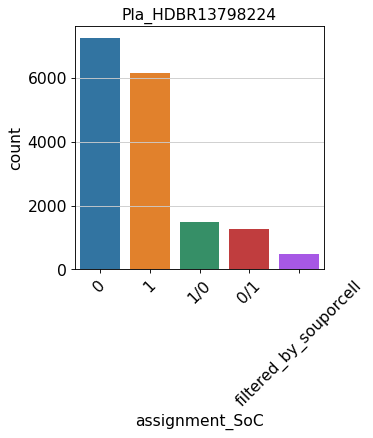

In [19]:
plt.title(sample)
sns.countplot(adata[adata.obs['sample'] == sample].obs['assignment_SoC'],
                order=adata[adata.obs['sample'] == sample].obs['assignment_SoC'].value_counts().index).set_title(sample)

plt.savefig(fig_path+'Tg_countplot_souporcell_id.pdf')
plt.xticks(rotation=45)

In [20]:
def donor_assing(adata_obj, cell_id):
    
    '''
    Function that assings a donor ID to the cells that were pooled and not pooled. It keep the ID stored in donor_deconv for those cells
    pooled, and the cells that weren't pooled will keep the original donor ID before deconvolution donor.
    
    input
        adata_obj: adata object
        cell_id:

    '''
    
    #Donor deconvoluted of the current cell
    curr_donor_deconv = adata_obj.obs.loc[cell_id, 'donor_deconv']
    #Donor of the current cell (before deconvolution)
    curr_donor = adata_obj.obs.loc[cell_id, 'donor']
    
    # donor ID from 'donor_id' column
    
    #If the curr_donor_deconv is None, then the function willl return the donor before deconvolution
    # Otherwise it will return the same donor in the donor_deconv column. Which is the real donor. 
    if curr_donor_deconv == 'None':
        return(curr_donor)
    
    elif curr_donor_deconv == None:
        return(curr_donor)
    
    else:
        return(curr_donor_deconv)

    

In [21]:
#applying the donor_assing function to the data. The donor names will be stored in the new column donor_souporcell
adata.obs['donor_souporcell'] = adata.obs['sample_barcode'].apply(lambda x: donor_assing(adata,x))

In [22]:
adata.obs

,sample,stage,donor,hpi,infection,percent_mito,n_counts,batch,sample_barcode,assignment_SoC,donor_deconv,donor_souporcell
Pla_HDBR13007974_AAACCCAAGAAGAGCA,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.001482,5397.0,0,Pla_HDBR13007974_AAACCCAAGAAGAGCA,0,0,0
Pla_HDBR13007974_AAACCCAAGCGTTGTT,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.019590,6432.0,0,Pla_HDBR13007974_AAACCCAAGCGTTGTT,1,1,1
Pla_HDBR13007974_AAACCCAAGTAGTCAA,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.045489,49221.0,0,Pla_HDBR13007974_AAACCCAAGTAGTCAA,0,0,0
Pla_HDBR13007974_AAACCCACAATGAACA,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.045332,9243.0,0,Pla_HDBR13007974_AAACCCACAATGAACA,1,1,1
Pla_HDBR13007974_AAACCCACAGAGAGGG,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.031214,7753.0,0,Pla_HDBR13007974_AAACCCACAGAGAGGG,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
Pla_HDBR13798224_TTTGTTGTCCTGTTAT,Pla_HDBR13798224,Tg_24h,Hrv241_Hrv242,24h,Tg,0.703766,1779.0,3,Pla_HDBR13798224_TTTGTTGTCCTGTTAT,1/0,donor_doublets,donor_doublets
Pla_HDBR13798224_TTTGTTGTCGTAGAGG,Pla_HDBR13798224,Tg_24h,Hrv241_Hrv242,24h,Tg,0.209441,11101.0,3,Pla_HDBR13798224_TTTGTTGTCGTAGAGG,1,2,2
Pla_HDBR13798224_TTTGTTGTCTCATGGA,Pla_HDBR13798224,Tg_24h,Hrv241_Hrv242,24h,Tg,0.072021,45945.0,3,Pla_HDBR13798224_TTTGTTGTCTCATGGA,1,2,2
Pla_HDBR13798224_TTTGTTGTCTCCACTG,Pla_HDBR13798224,Tg_24h,Hrv241_Hrv242,24h,Tg,0.748331,1947.0,3,Pla_HDBR13798224_TTTGTTGTCTCCACTG,1/0,donor_doublets,donor_doublets


In [23]:
#Deleting the cells filtered by soc
adata= adata[adata.obs['assignment_SoC'] != 'filtered_by_souporcell']

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [24]:
adata.obs.head()

,sample,stage,donor,hpi,infection,percent_mito,n_counts,batch,sample_barcode,assignment_SoC,donor_deconv,donor_souporcell
Pla_HDBR13007974_AAACCCAAGAAGAGCA,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.001482,5397.0,0,Pla_HDBR13007974_AAACCCAAGAAGAGCA,0,0,0
Pla_HDBR13007974_AAACCCAAGCGTTGTT,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.019590,6432.0,0,Pla_HDBR13007974_AAACCCAAGCGTTGTT,1,1,1
Pla_HDBR13007974_AAACCCAAGTAGTCAA,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.045489,49221.0,0,Pla_HDBR13007974_AAACCCAAGTAGTCAA,0,0,0
Pla_HDBR13007974_AAACCCACAATGAACA,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.045332,9243.0,0,Pla_HDBR13007974_AAACCCACAATGAACA,1,1,1
Pla_HDBR13007974_AAACCCACAGAGAGGG,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.031214,7753.0,0,Pla_HDBR13007974_AAACCCACAGAGAGGG,1,1,1


#### Assigning donor id to cluster
I had deconvoluted and matched the 2 different donors in my data set, however I don't really know what cluster is each one of the donors.

I cannot know which donor is each cluster therefore an ID will assign to each donor.

**Donors**: Hrv171, Hrv172, Hrv241 and Hrv242

**ID**: scDonor_Tg1, scDonor_Tg2, scDonor_Tg3, scDonor_Tg4

In [25]:
set(list(adata.obs.donor_souporcell))

{'0', '1', '2', '3', 'donor_doublets'}

In [26]:
#Function that changes the cluster names as indicated
adata.obs['donor_id'] = (adata.obs["donor_souporcell"].map(lambda x: 
                            {"0": "scDonor_Tg1", "1": "scDonor_Tg2",
                             "2": "scDonor_Tg3", "3": "scDonor_Tg4",
                             "souporcell_doublet":"donor_doublets" }
                            .get(x, x)).astype("category"))

Trying to set attribute `.obs` of view, copying.


In [27]:
set(list(adata.obs.donor_id))

{'donor_doublets', 'scDonor_Tg1', 'scDonor_Tg2', 'scDonor_Tg3', 'scDonor_Tg4'}

In [28]:
print('Total number of cells: {:d}'.format(adata.n_obs))

Total number of cells: 66451


In [29]:
adata.obs= adata.obs.drop(columns=['donor_deconv','donor_souporcell'])

In [30]:
adata.obs

,sample,stage,donor,hpi,infection,percent_mito,n_counts,batch,sample_barcode,assignment_SoC,donor_id
Pla_HDBR13007974_AAACCCAAGAAGAGCA,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.001482,5397.0,0,Pla_HDBR13007974_AAACCCAAGAAGAGCA,0,scDonor_Tg1
Pla_HDBR13007974_AAACCCAAGCGTTGTT,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.019590,6432.0,0,Pla_HDBR13007974_AAACCCAAGCGTTGTT,1,scDonor_Tg2
Pla_HDBR13007974_AAACCCAAGTAGTCAA,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.045489,49221.0,0,Pla_HDBR13007974_AAACCCAAGTAGTCAA,0,scDonor_Tg1
Pla_HDBR13007974_AAACCCACAATGAACA,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.045332,9243.0,0,Pla_HDBR13007974_AAACCCACAATGAACA,1,scDonor_Tg2
Pla_HDBR13007974_AAACCCACAGAGAGGG,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.031214,7753.0,0,Pla_HDBR13007974_AAACCCACAGAGAGGG,1,scDonor_Tg2
...,...,...,...,...,...,...,...,...,...,...,...
Pla_HDBR13798224_TTTGTTGTCCTGTTAT,Pla_HDBR13798224,Tg_24h,Hrv241_Hrv242,24h,Tg,0.703766,1779.0,3,Pla_HDBR13798224_TTTGTTGTCCTGTTAT,1/0,donor_doublets
Pla_HDBR13798224_TTTGTTGTCGTAGAGG,Pla_HDBR13798224,Tg_24h,Hrv241_Hrv242,24h,Tg,0.209441,11101.0,3,Pla_HDBR13798224_TTTGTTGTCGTAGAGG,1,scDonor_Tg3
Pla_HDBR13798224_TTTGTTGTCTCATGGA,Pla_HDBR13798224,Tg_24h,Hrv241_Hrv242,24h,Tg,0.072021,45945.0,3,Pla_HDBR13798224_TTTGTTGTCTCATGGA,1,scDonor_Tg3
Pla_HDBR13798224_TTTGTTGTCTCCACTG,Pla_HDBR13798224,Tg_24h,Hrv241_Hrv242,24h,Tg,0.748331,1947.0,3,Pla_HDBR13798224_TTTGTTGTCTCCACTG,1/0,donor_doublets


In [31]:
data_dir

'/lustre/scratch126/cellgen/team292/er13/PlacInfection_revision/scRNAseq/data_integration/data/Toxoplasma/'

# Scrublet

In [32]:
scorenames = ['scrublet_score','scrublet_cluster_score','zscore','bh_pval','bonf_pval']

scrdf = []
for sample in meta.index:
    #reading the scrublet scores done in S0
    scrdf.append(pd.read_csv(data_dir+'scrublet-scores/'+sample+'.csv', header=0, index_col=0))
#scrdf.append(pd.read_csv('scrublet-scores/'+sample+'.csv', header=0, index_col=0))
#scrdf.append(pd.read_csv('scrublet-scores/'+sample+'soupX.csv', header=0, index_col=0))
scrdf = pd.concat(scrdf)
scrdf.index = [i.replace('-1', '') for i in scrdf.index]
for score in scorenames:
    adata.obs[score] = scrdf[score]
# In scrublet the significant p-value mark doublets
adata.obs['is_doublet'] = adata.obs['bonf_pval'] < 0.01

In [33]:
print('Total number of doublets: {:d}'.format(len(adata.obs.loc[adata.obs['is_doublet'] == True])))

Total number of doublets: 2192


In [34]:
adata.obs.head()

,sample,stage,donor,hpi,infection,percent_mito,n_counts,batch,sample_barcode,assignment_SoC,donor_id,scrublet_score,scrublet_cluster_score,zscore,bh_pval,bonf_pval,is_doublet
Pla_HDBR13007974_AAACCCAAGAAGAGCA,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.001482,5397.0,0,Pla_HDBR13007974_AAACCCAAGAAGAGCA,0,scDonor_Tg1,0.022316,0.027244,-1.040029,0.956054,1.0,False
Pla_HDBR13007974_AAACCCAAGCGTTGTT,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.019590,6432.0,0,Pla_HDBR13007974_AAACCCAAGCGTTGTT,1,scDonor_Tg2,0.020057,0.029250,-0.970364,0.946081,1.0,False
Pla_HDBR13007974_AAACCCAAGTAGTCAA,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.045489,49221.0,0,Pla_HDBR13007974_AAACCCAAGTAGTCAA,0,scDonor_Tg1,0.092913,0.083395,0.909816,0.899034,1.0,False
Pla_HDBR13007974_AAACCCACAATGAACA,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.045332,9243.0,0,Pla_HDBR13007974_AAACCCACAATGAACA,1,scDonor_Tg2,0.085202,0.073439,0.564082,0.899034,1.0,False
Pla_HDBR13007974_AAACCCACAGAGAGGG,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.031214,7753.0,0,Pla_HDBR13007974_AAACCCACAGAGAGGG,1,scDonor_Tg2,0.099262,0.070423,0.459349,0.909845,1.0,False


In [35]:
#concatenating columns and creating new one
adata.obs["infection_stage"] = adata.obs["infection"].astype('string') +'_'+ adata.obs["hpi"]

In [36]:
adata.obs["infection_stage"] = adata.obs["infection_stage"].astype("category")

In [37]:
set(adata.obs["infection_stage"])

{'Tg_24h', 'UI_24h'}

In [38]:
adata.obs

,sample,stage,donor,hpi,infection,percent_mito,n_counts,batch,sample_barcode,assignment_SoC,donor_id,scrublet_score,scrublet_cluster_score,zscore,bh_pval,bonf_pval,is_doublet,infection_stage
Pla_HDBR13007974_AAACCCAAGAAGAGCA,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.001482,5397.0,0,Pla_HDBR13007974_AAACCCAAGAAGAGCA,0,scDonor_Tg1,0.022316,0.027244,-1.040029,0.956054,1.0,False,UI_24h
Pla_HDBR13007974_AAACCCAAGCGTTGTT,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.019590,6432.0,0,Pla_HDBR13007974_AAACCCAAGCGTTGTT,1,scDonor_Tg2,0.020057,0.029250,-0.970364,0.946081,1.0,False,UI_24h
Pla_HDBR13007974_AAACCCAAGTAGTCAA,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.045489,49221.0,0,Pla_HDBR13007974_AAACCCAAGTAGTCAA,0,scDonor_Tg1,0.092913,0.083395,0.909816,0.899034,1.0,False,UI_24h
Pla_HDBR13007974_AAACCCACAATGAACA,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.045332,9243.0,0,Pla_HDBR13007974_AAACCCACAATGAACA,1,scDonor_Tg2,0.085202,0.073439,0.564082,0.899034,1.0,False,UI_24h
Pla_HDBR13007974_AAACCCACAGAGAGGG,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.031214,7753.0,0,Pla_HDBR13007974_AAACCCACAGAGAGGG,1,scDonor_Tg2,0.099262,0.070423,0.459349,0.909845,1.0,False,UI_24h
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pla_HDBR13798224_TTTGTTGTCCTGTTAT,Pla_HDBR13798224,Tg_24h,Hrv241_Hrv242,24h,Tg,0.703766,1779.0,3,Pla_HDBR13798224_TTTGTTGTCCTGTTAT,1/0,donor_doublets,0.015119,0.019177,-3.346372,0.999652,1.0,False,Tg_24h
Pla_HDBR13798224_TTTGTTGTCGTAGAGG,Pla_HDBR13798224,Tg_24h,Hrv241_Hrv242,24h,Tg,0.209441,11101.0,3,Pla_HDBR13798224_TTTGTTGTCGTAGAGG,1,scDonor_Tg3,0.014669,0.044088,-1.848236,0.999652,1.0,False,Tg_24h
Pla_HDBR13798224_TTTGTTGTCTCATGGA,Pla_HDBR13798224,Tg_24h,Hrv241_Hrv242,24h,Tg,0.072021,45945.0,3,Pla_HDBR13798224_TTTGTTGTCTCATGGA,1,scDonor_Tg3,0.061511,0.075568,0.044945,0.973885,1.0,False,Tg_24h
Pla_HDBR13798224_TTTGTTGTCTCCACTG,Pla_HDBR13798224,Tg_24h,Hrv241_Hrv242,24h,Tg,0.748331,1947.0,3,Pla_HDBR13798224_TTTGTTGTCTCCACTG,1/0,donor_doublets,0.019939,0.022320,-3.157363,0.999652,1.0,False,Tg_24h


In [39]:
# adding the raw counts
adata.layers['raw_counts']=adata.X

## Calculate cell-cycle scores AND (optional)regress out cell cycle genes

We here perform cell cycle scoring. To score a gene list, the algorithm calculates the difference of mean expression of the given list and the mean expression of reference genes. To build the reference, the function randomly chooses a bunch of genes matching the distribution of the expression of the given list. Cell cycle scoring adds three slots in data, a score for S phase, a score for G2M phase and the predicted cell cycle phase.

First read the file with cell cycle genes, from Regev lab and split into S and G2M phase genes. Cell cycle genes were retrieved from the scanpy_usage github site via web browser at RegevLab Github repo.

In [40]:
#Normalizing the data and scaling for the cell-cycle scoring
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)


# Scale
sc.pp.scale(adata, max_value=10)

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [41]:
# calculate cell cycle scores

cell_cycle_genes = [x.strip() for x in open('../data/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes = [x for x in g2m_genes if x in adata.var_names]
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
# sc.pp.regress_out(adata, ['S_score', 'G2M_score']

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [42]:
adata.obs

,sample,stage,donor,hpi,infection,percent_mito,n_counts,batch,sample_barcode,assignment_SoC,...,scrublet_score,scrublet_cluster_score,zscore,bh_pval,bonf_pval,is_doublet,infection_stage,S_score,G2M_score,phase
Pla_HDBR13007974_AAACCCAAGAAGAGCA,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.001482,5397.0,0,Pla_HDBR13007974_AAACCCAAGAAGAGCA,0,...,0.022316,0.027244,-1.040029,0.956054,1.0,False,UI_24h,-0.120853,-0.030800,G1
Pla_HDBR13007974_AAACCCAAGCGTTGTT,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.019590,6432.0,0,Pla_HDBR13007974_AAACCCAAGCGTTGTT,1,...,0.020057,0.029250,-0.970364,0.946081,1.0,False,UI_24h,-0.169753,-0.185258,G1
Pla_HDBR13007974_AAACCCAAGTAGTCAA,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.045489,49221.0,0,Pla_HDBR13007974_AAACCCAAGTAGTCAA,0,...,0.092913,0.083395,0.909816,0.899034,1.0,False,UI_24h,-0.046311,-0.153001,G1
Pla_HDBR13007974_AAACCCACAATGAACA,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.045332,9243.0,0,Pla_HDBR13007974_AAACCCACAATGAACA,1,...,0.085202,0.073439,0.564082,0.899034,1.0,False,UI_24h,-0.050709,-0.060906,G1
Pla_HDBR13007974_AAACCCACAGAGAGGG,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.031214,7753.0,0,Pla_HDBR13007974_AAACCCACAGAGAGGG,1,...,0.099262,0.070423,0.459349,0.909845,1.0,False,UI_24h,-0.048443,0.100363,G2M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pla_HDBR13798224_TTTGTTGTCCTGTTAT,Pla_HDBR13798224,Tg_24h,Hrv241_Hrv242,24h,Tg,0.703766,1779.0,3,Pla_HDBR13798224_TTTGTTGTCCTGTTAT,1/0,...,0.015119,0.019177,-3.346372,0.999652,1.0,False,Tg_24h,-0.097645,-0.100616,G1
Pla_HDBR13798224_TTTGTTGTCGTAGAGG,Pla_HDBR13798224,Tg_24h,Hrv241_Hrv242,24h,Tg,0.209441,11101.0,3,Pla_HDBR13798224_TTTGTTGTCGTAGAGG,1,...,0.014669,0.044088,-1.848236,0.999652,1.0,False,Tg_24h,-0.235435,-0.144787,G1
Pla_HDBR13798224_TTTGTTGTCTCATGGA,Pla_HDBR13798224,Tg_24h,Hrv241_Hrv242,24h,Tg,0.072021,45945.0,3,Pla_HDBR13798224_TTTGTTGTCTCATGGA,1,...,0.061511,0.075568,0.044945,0.973885,1.0,False,Tg_24h,1.557284,0.051301,S
Pla_HDBR13798224_TTTGTTGTCTCCACTG,Pla_HDBR13798224,Tg_24h,Hrv241_Hrv242,24h,Tg,0.748331,1947.0,3,Pla_HDBR13798224_TTTGTTGTCTCCACTG,1/0,...,0.019939,0.022320,-3.157363,0.999652,1.0,False,Tg_24h,-0.101221,0.007270,G2M


## Save raw counts

In [43]:
# adding the raw counts
adata.X=adata.layers['raw_counts'].copy()
#adata.raw = adata.copy
adata.write('../data/rna1_counts_Tg_adata.h5ad')

... storing 'sample' as categorical
... storing 'stage' as categorical
... storing 'donor' as categorical
... storing 'hpi' as categorical
... storing 'infection' as categorical
... storing 'assignment_SoC' as categorical
... storing 'phase' as categorical
... storing 'feature_types' as categorical


In [44]:
#adata=sc.read('../data/rna1_counts_Tg_adata.h5ad')

In [45]:
adata

AnnData object with n_obs × n_vars = 66451 × 45238
    obs: 'sample', 'stage', 'donor', 'hpi', 'infection', 'percent_mito', 'n_counts', 'batch', 'sample_barcode', 'assignment_SoC', 'donor_id', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'infection_stage', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'mean', 'std'
    uns: 'log1p'
    layers: 'raw_counts'

## Preview of Toxoplasma gondii UMIs

Looking at the human and Tg genes.

All the Tg genes have the preffix "TGGT1" 

In [46]:
adata.var.head()

,gene_ids,feature_types,mean,std
MIR1302-2HG,ENSG00000243485,Gene Expression,0.000066,0.006049
FAM138A,ENSG00000237613,Gene Expression,0.000003,0.000704
OR4F5,ENSG00000186092,Gene Expression,0.000000,1.000000
AL627309.1,ENSG00000238009,Gene Expression,0.007670,0.066799
AL627309.3,ENSG00000239945,Gene Expression,0.000000,1.000000


In [47]:
adata.var.tail()

,gene_ids,feature_types,mean,std
TGGT1_412230,TGGT1_412230,Gene Expression,0.0,1.0
TGGT1_412240,TGGT1_412240,Gene Expression,0.0,1.0
TGGT1_412250,TGGT1_412250,Gene Expression,0.0,1.0
TGGT1_412260,TGGT1_412260,Gene Expression,0.0,1.0
TGGT1_300641,TGGT1_300641,Gene Expression,0.0,1.0


In [48]:
## Selecting the names of the Tg genes only
tg= adata.var.index.str.contains('TGGT1')
print(sum(tg))

8637


In [49]:
adata.obs.head()

,sample,stage,donor,hpi,infection,percent_mito,n_counts,batch,sample_barcode,assignment_SoC,...,scrublet_score,scrublet_cluster_score,zscore,bh_pval,bonf_pval,is_doublet,infection_stage,S_score,G2M_score,phase
Pla_HDBR13007974_AAACCCAAGAAGAGCA,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.001482,5397.0,0,Pla_HDBR13007974_AAACCCAAGAAGAGCA,0,...,0.022316,0.027244,-1.040029,0.956054,1.0,False,UI_24h,-0.120853,-0.030800,G1
Pla_HDBR13007974_AAACCCAAGCGTTGTT,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.019590,6432.0,0,Pla_HDBR13007974_AAACCCAAGCGTTGTT,1,...,0.020057,0.029250,-0.970364,0.946081,1.0,False,UI_24h,-0.169753,-0.185258,G1
Pla_HDBR13007974_AAACCCAAGTAGTCAA,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.045489,49221.0,0,Pla_HDBR13007974_AAACCCAAGTAGTCAA,0,...,0.092913,0.083395,0.909816,0.899034,1.0,False,UI_24h,-0.046311,-0.153001,G1
Pla_HDBR13007974_AAACCCACAATGAACA,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.045332,9243.0,0,Pla_HDBR13007974_AAACCCACAATGAACA,1,...,0.085202,0.073439,0.564082,0.899034,1.0,False,UI_24h,-0.050709,-0.060906,G1
Pla_HDBR13007974_AAACCCACAGAGAGGG,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.031214,7753.0,0,Pla_HDBR13007974_AAACCCACAGAGAGGG,1,...,0.099262,0.070423,0.459349,0.909845,1.0,False,UI_24h,-0.048443,0.100363,G2M


In [50]:
adata.obs.tail()

,sample,stage,donor,hpi,infection,percent_mito,n_counts,batch,sample_barcode,assignment_SoC,...,scrublet_score,scrublet_cluster_score,zscore,bh_pval,bonf_pval,is_doublet,infection_stage,S_score,G2M_score,phase
Pla_HDBR13798224_TTTGTTGTCCTGTTAT,Pla_HDBR13798224,Tg_24h,Hrv241_Hrv242,24h,Tg,0.703766,1779.0,3,Pla_HDBR13798224_TTTGTTGTCCTGTTAT,1/0,...,0.015119,0.019177,-3.346372,0.999652,1.0,False,Tg_24h,-0.097645,-0.100616,G1
Pla_HDBR13798224_TTTGTTGTCGTAGAGG,Pla_HDBR13798224,Tg_24h,Hrv241_Hrv242,24h,Tg,0.209441,11101.0,3,Pla_HDBR13798224_TTTGTTGTCGTAGAGG,1,...,0.014669,0.044088,-1.848236,0.999652,1.0,False,Tg_24h,-0.235435,-0.144787,G1
Pla_HDBR13798224_TTTGTTGTCTCATGGA,Pla_HDBR13798224,Tg_24h,Hrv241_Hrv242,24h,Tg,0.072021,45945.0,3,Pla_HDBR13798224_TTTGTTGTCTCATGGA,1,...,0.061511,0.075568,0.044945,0.973885,1.0,False,Tg_24h,1.557284,0.051301,S
Pla_HDBR13798224_TTTGTTGTCTCCACTG,Pla_HDBR13798224,Tg_24h,Hrv241_Hrv242,24h,Tg,0.748331,1947.0,3,Pla_HDBR13798224_TTTGTTGTCTCCACTG,1/0,...,0.019939,0.022320,-3.157363,0.999652,1.0,False,Tg_24h,-0.101221,0.007270,G2M
Pla_HDBR13798224_TTTGTTGTCTTGGGCG,Pla_HDBR13798224,Tg_24h,Hrv241_Hrv242,24h,Tg,0.021015,41779.0,3,Pla_HDBR13798224_TTTGTTGTCTTGGGCG,1,...,0.292308,0.075568,0.044945,0.973885,1.0,False,Tg_24h,1.473958,-0.045923,S


In [51]:
adata

AnnData object with n_obs × n_vars = 66451 × 45238
    obs: 'sample', 'stage', 'donor', 'hpi', 'infection', 'percent_mito', 'n_counts', 'batch', 'sample_barcode', 'assignment_SoC', 'donor_id', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'infection_stage', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'mean', 'std'
    uns: 'log1p'
    layers: 'raw_counts'

<ipython-input-2-b5d44fa15e4e>:32: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimize" which is no longer supported as of 3.3 and will become an error two minor releases later
  ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+ suffix+'.pdf', bbox_inches='tight',


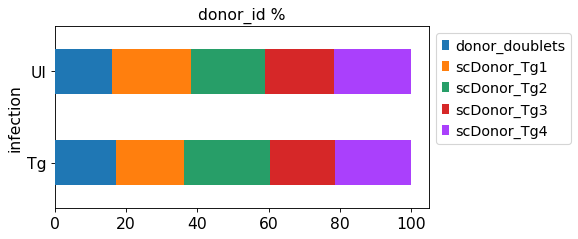

In [52]:
## --- To be run once the deconvolution is completed

Barplot('donor_id', adata, var= 'infection')

#### Giving a flag to differentiate human and Tg genes in my data set. Preview of counts

In [53]:
## Giving a flag to differentiate human and Tg genes in my data set
##
adata.var['hs'] = adata.var.gene_ids.str.startswith('ENSG') ## all human genes
adata.var['tg'] = adata.var.gene_ids.str.startswith('TGGT1') ## all toxoplasma genes


## Calculating the metrics per cell in my data.
sc.pp.calculate_qc_metrics(adata, qc_vars=['hs'], percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata, qc_vars=['tg'], percent_top=None, log1p=False, inplace=True)

In [54]:
## Look at the hs and tg columns
adata.var

,gene_ids,feature_types,mean,std,hs,tg,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
MIR1302-2HG,ENSG00000243485,Gene Expression,0.000066,0.006049,True,False,11,0.000166,99.983446,11.0
FAM138A,ENSG00000237613,Gene Expression,0.000003,0.000704,True,False,1,0.000015,99.998495,1.0
OR4F5,ENSG00000186092,Gene Expression,0.000000,1.000000,True,False,0,0.000000,100.000000,0.0
AL627309.1,ENSG00000238009,Gene Expression,0.007670,0.066799,True,False,1166,0.018450,98.245324,1226.0
AL627309.3,ENSG00000239945,Gene Expression,0.000000,1.000000,True,False,0,0.000000,100.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
TGGT1_412230,TGGT1_412230,Gene Expression,0.000000,1.000000,False,True,0,0.000000,100.000000,0.0
TGGT1_412240,TGGT1_412240,Gene Expression,0.000000,1.000000,False,True,0,0.000000,100.000000,0.0
TGGT1_412250,TGGT1_412250,Gene Expression,0.000000,1.000000,False,True,0,0.000000,100.000000,0.0
TGGT1_412260,TGGT1_412260,Gene Expression,0.000000,1.000000,False,True,0,0.000000,100.000000,0.0


In [55]:
## Look at the total_counts_hs and total_counts_tg columns
##
adata.obs.head()

,sample,stage,donor,hpi,infection,percent_mito,n_counts,batch,sample_barcode,assignment_SoC,...,infection_stage,S_score,G2M_score,phase,n_genes_by_counts,total_counts,total_counts_hs,pct_counts_hs,total_counts_tg,pct_counts_tg
Pla_HDBR13007974_AAACCCAAGAAGAGCA,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.001482,5397.0,0,Pla_HDBR13007974_AAACCCAAGAAGAGCA,0,...,UI_24h,-0.120853,-0.030800,G1,569,5397.0,5397.0,100.0,0.0,0.0
Pla_HDBR13007974_AAACCCAAGCGTTGTT,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.019590,6432.0,0,Pla_HDBR13007974_AAACCCAAGCGTTGTT,1,...,UI_24h,-0.169753,-0.185258,G1,1904,6432.0,6432.0,100.0,0.0,0.0
Pla_HDBR13007974_AAACCCAAGTAGTCAA,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.045489,49221.0,0,Pla_HDBR13007974_AAACCCAAGTAGTCAA,0,...,UI_24h,-0.046311,-0.153001,G1,5525,49221.0,49221.0,100.0,0.0,0.0
Pla_HDBR13007974_AAACCCACAATGAACA,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.045332,9243.0,0,Pla_HDBR13007974_AAACCCACAATGAACA,1,...,UI_24h,-0.050709,-0.060906,G1,3032,9243.0,9243.0,100.0,0.0,0.0
Pla_HDBR13007974_AAACCCACAGAGAGGG,Pla_HDBR13007974,UI_24h,Hrv171_Hrv172,24h,UI,0.031214,7753.0,0,Pla_HDBR13007974_AAACCCACAGAGAGGG,1,...,UI_24h,-0.048443,0.100363,G2M,2803,7753.0,7753.0,100.0,0.0,0.0


In [56]:
## Look at the total_counts_hs and total_counts_tg columns
##
adata.obs.tail()

,sample,stage,donor,hpi,infection,percent_mito,n_counts,batch,sample_barcode,assignment_SoC,...,infection_stage,S_score,G2M_score,phase,n_genes_by_counts,total_counts,total_counts_hs,pct_counts_hs,total_counts_tg,pct_counts_tg
Pla_HDBR13798224_TTTGTTGTCCTGTTAT,Pla_HDBR13798224,Tg_24h,Hrv241_Hrv242,24h,Tg,0.703766,1779.0,3,Pla_HDBR13798224_TTTGTTGTCCTGTTAT,1/0,...,Tg_24h,-0.097645,-0.100616,G1,360,1779.0,1779.0,100.0,0.0,0.0
Pla_HDBR13798224_TTTGTTGTCGTAGAGG,Pla_HDBR13798224,Tg_24h,Hrv241_Hrv242,24h,Tg,0.209441,11101.0,3,Pla_HDBR13798224_TTTGTTGTCGTAGAGG,1,...,Tg_24h,-0.235435,-0.144787,G1,3247,11101.0,11101.0,100.0,0.0,0.0
Pla_HDBR13798224_TTTGTTGTCTCATGGA,Pla_HDBR13798224,Tg_24h,Hrv241_Hrv242,24h,Tg,0.072021,45945.0,3,Pla_HDBR13798224_TTTGTTGTCTCATGGA,1,...,Tg_24h,1.557284,0.051301,S,6817,45945.0,45945.0,100.0,0.0,0.0
Pla_HDBR13798224_TTTGTTGTCTCCACTG,Pla_HDBR13798224,Tg_24h,Hrv241_Hrv242,24h,Tg,0.748331,1947.0,3,Pla_HDBR13798224_TTTGTTGTCTCCACTG,1/0,...,Tg_24h,-0.101221,0.007270,G2M,348,1947.0,1947.0,100.0,0.0,0.0
Pla_HDBR13798224_TTTGTTGTCTTGGGCG,Pla_HDBR13798224,Tg_24h,Hrv241_Hrv242,24h,Tg,0.021015,41779.0,3,Pla_HDBR13798224_TTTGTTGTCTTGGGCG,1,...,Tg_24h,1.473958,-0.045923,S,7287,41779.0,41779.0,100.0,0.0,0.0


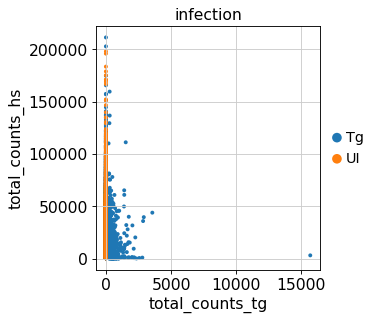

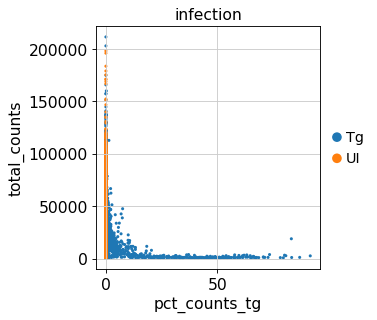

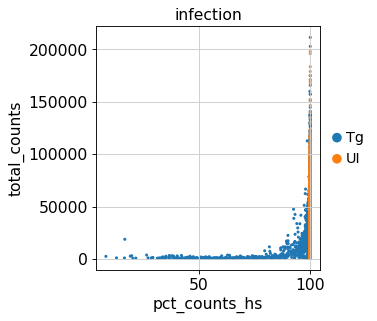

In [57]:
sc.pl.scatter(adata, x='total_counts_tg', y='total_counts_hs',  color="infection",size=50, save='_HsTgCounts.pdf')
sc.pl.scatter(adata, x='pct_counts_tg', y='total_counts', color="infection", size=30, save='_TotalvsTg.pdf')
sc.pl.scatter(adata, x='pct_counts_hs', y='total_counts', color="infection", size=30, save='_TotalvsHs.pdf')

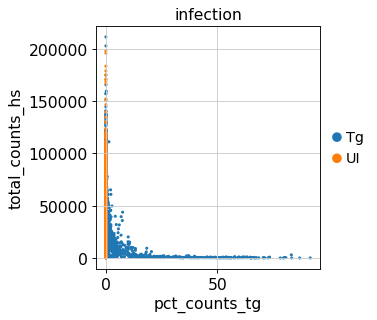

In [58]:
sc.pl.scatter(adata, x='pct_counts_tg', y='total_counts_hs', color="infection", size=30, save='_TgvsHs.pdf')

In [59]:
print('Total number of cells: {:d}'.format(adata.n_obs))

Total number of cells: 66451


In [60]:
adata.obs['sample'].values.describe()

,counts,freqs
categories,,
Pla_HDBR13007974,16097,0.242239
Pla_HDBR13007975,17711,0.266527
Pla_HDBR13798223,16498,0.248273
Pla_HDBR13798224,16145,0.242961


#### Checking if uninfected cells have random (or not) counts from *T. gondii*

In [61]:
# percentage in a droplet has mostly human genes
#cells with more than 10% of Tg counts
sum(adata.obs.pct_counts_tg > 10)

250

In [62]:
## Uninfected:
# cells with more than 0% of Tg counts

nCells_infectedSamples=adata[adata.obs['infection'] == 'UI'].n_obs
print('Total cells from Uninfected explants: {:d}'.format(nCells_infectedSamples))

adata_temp= adata[adata.obs['infection'] == 'UI']
print('Cells with Tg counts >0%: {:d}'.format(sum(adata_temp.obs.pct_counts_tg > 0)))
print('Cells with Tg counts >0.07%: {:d}'.format(sum(adata_temp.obs.pct_counts_tg > 0.07)))
print('Cells with Tg counts >1%: {:d}'.format(sum(adata_temp.obs.pct_counts_tg > 1)))

Total cells from Uninfected explants: 32595
Cells with Tg counts >0%: 90
Cells with Tg counts >0.07%: 1
Cells with Tg counts >1%: 0


/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


There are 108 with >0% of Tg counts. However, none of the cells have >0.07% of Tg counts. I will set this value as the value of Tg counts expected by chance, this will be my threshold to decide which cells are infected or not

In [63]:
## Infected explants
#cells with more than 0% of Tg counts

nCells_infectedSamples=adata[adata.obs['infection'] == 'Tg'].n_obs
print('Total cells from infected explants: {:d}'.format(nCells_infectedSamples))

adata_temp= adata[adata.obs['infection'] == 'Tg']
print('Cells with Tg counts >0%: {:d}'.format(sum(adata_temp.obs.pct_counts_tg > 0)))
print('Cells with Tg counts >0.07%: {:d}'.format(sum(adata_temp.obs.pct_counts_tg > 0.07)))
print('Cells with Tg counts >0.5%: {:d}'.format(sum(adata_temp.obs.pct_counts_tg > 0.5)))
print('Cells with Tg counts >1%: {:d}'.format(sum(adata_temp.obs.pct_counts_tg > 1)))

Total cells from infected explants: 33856
Cells with Tg counts >0%: 4610
Cells with Tg counts >0.07%: 1184
Cells with Tg counts >0.5%: 806
Cells with Tg counts >1%: 686


/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [64]:
del(adata_temp)

### Adding a flag to the metadata indicating if a cell is infected or not

The criteria is to have a % of Tg counts >0.07

In [65]:
#Selecting the cells with %Tg>0
temp=adata.obs.pct_counts_tg > 0.07

#Adding aa new column with the flag in it. Boolean.
adata.obs['Tg_infected']= temp.astype("string")

## Save raw counts

In [66]:
# adding the raw counts
adata.X=adata.layers['raw_counts'].copy()
#adata.raw = adata.copy
adata.write('../data/rna1_counts_Tg_adata.h5ad')

... storing 'Tg_infected' as categorical
